**NOTE:** The FITS file used below can be obtained from the STScI MAST archive:
[link](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CAOMFILTERED%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22obs_collection%22%2C%22niceName%22%3A%22obs_collection%22%2C%22values%22%3A%5B%22HST%22%5D%2C%22valString%22%3A%22HST%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22HST%22%7D%2C%7B%22paramName%22%3A%22instrument_name%22%2C%22niceName%22%3A%22instrument_name%22%2C%22values%22%3A%5B%22ACS%2FWFC%22%5D%2C%22valString%22%3A%22ACS%2FWFC%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22ACS%2FWFC%22%7D%2C%7B%22paramName%22%3A%22filters%22%2C%22niceName%22%3A%22filters%22%2C%22values%22%3A%5B%22F814W%22%5D%2C%22valString%22%3A%22F814W%22%2C%22isDate%22%3Afalse%2C%22separator%22%3A%22%3B%22%2C%22facetType%22%3A%22discrete%22%2C%22displayString%22%3A%22F814W%22%7D%2C%7B%22paramName%22%3A%22t_min%22%2C%22niceName%22%3A%22t_min%22%2C%22values%22%3A%5B%7B%22min%22%3A57332%2C%22max%22%3A57333%7D%5D%2C%22valString%22%3A%22%5B57332%2C%2057333%5D%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22numeric%22%2C%22min%22%3A57332%2C%22max%22%3A57333%2C%22displayString%22%3A%22%5B57332%2C%2057333%5D%22%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Caom.Filtered%22%2C%22title%22%3A%22MAST%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22HST%3B%20ACS%2FWFC%3B%20F814W%3B%20%5B57332%2C%2057333%5D%3B%20%20abell%20s1063%3B%22%2C%22columns%22%3A%22*%22%7D)

In [1]:
# In this notebook, the GridFunction class is demonstated, examples
# of a subdivision grid are shown, as wel as an example of fitting
# a multiple plummer lens to some density function (in this case based
# on a FITS file)

In [2]:
# Lets load some modules and set some defaults
%matplotlib inline
import grale.gridfunction as gridfunction
import grale.grid as grid
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.renderers as renderers
import grale.cosmology as cosmology
from grale.constants import *
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as plt
import numpy as np

V = lambda x,y: np.array([x,y],dtype=np.double)

renderers.setDefaultLensPlaneRenderer("openmp")
renderers.setDefaultMassRenderer("openmp")
feedback.setDefaultFeedback("none")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

In [3]:
# Here's a 5.5 grid of values. The border is all zeros, so that when
# we request a value that's outside the grid and get a border value, this
# will be zero
data = np.array([ [ 0, 0, 0, 0, 0 ],
                  [ 0, 1, 2, 3, 0 ],
                  [ 0, 4, 5, 6, 0 ], 
                  [ 0, 7, 8, 9, 0 ],
                  [ 0, 0, 0, 0, 0 ] ], dtype=np.double)

# These are going to be the corner regions of the data grid above. Depending
# the 'sPixels' value below, the meaning is slightly different.
bl = V(2, 3)
tr = V(10, 9)

In [4]:
# This is a helper function that creates regularly spaced theta vectors
def createThetas(bottomLeft, topRight, numX, numY):
    thetas = np.empty([numY,numX,2], dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX),
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

In [5]:
# Using the helper function, we'll create a grid of vectors for which we're
# going to evaluate a GridFunction instance
x0, x1 = -5, 15
y0, y1 = -7, 13
evalgrid = createThetas([x0, y0], [x1, y1], 1024, 1024)

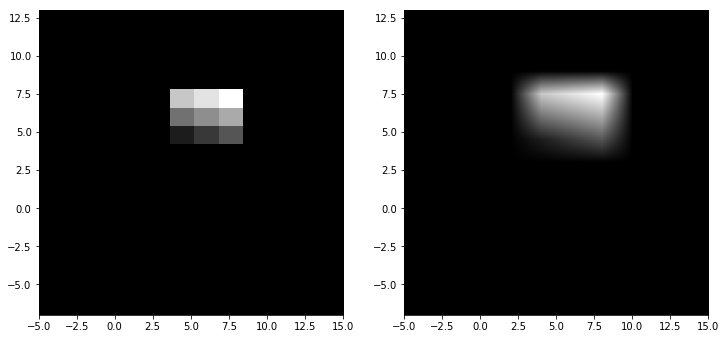

In [6]:
# Here we show the difference of the asPixels parameter when creating a grid function.
# In both cases, the grid function is based on the data matrix above, and can be evaluated
# for arbitrary coordinates. If they lie outside the data region, then the value will be
# that of the border. 

# If 'asPixels' is True, then the values returned will always be the values of the pixels
# themselfves, otherwise bilinear interpolation will be used. 
g = gridfunction.GridFunction(data, bl, tr, asPixels = True, rotationAngleRadians = 0)
g2 = gridfunction.GridFunction(data, bl, tr, asPixels = False, rotationAngleRadians = 0)

vals = g.evaluate(evalgrid, False)
vals2 = g2.evaluate(evalgrid, False)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(vals2, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

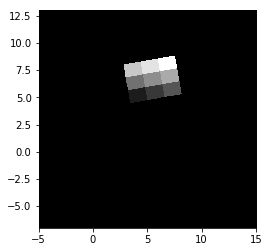

In [7]:
# For visualization purposes, we'll use the asPixels=True version, and we'll specify
# a rotation angle in the constructor. This means that the rectangular bottomleft/topright
# region will subsequently be rotated this amount (counterclockwise) around the bottomleft
# corner.
g = gridfunction.GridFunction(data, bl, tr, asPixels = True, rotationAngleRadians = np.pi/18)
vals = g.evaluate(evalgrid, False)
vals_A = vals

plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

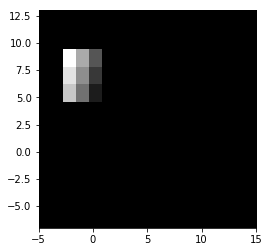

In [8]:
# Similar, but for 90 degrees
g = gridfunction.GridFunction(data, bl, tr, asPixels = True, rotationAngleRadians = 3.14/2)
vals = g.evaluate(evalgrid, False)

plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

In [9]:
# A helper function that gets the coordinates when rotating a position 'v'
# counterclockwise over an angle (in radians) 'a'
def rotate(v, a):
    return np.array([v[0]*np.cos(a) - v[1]*np.sin(a), v[0]*np.sin(a) + v[1]*np.cos(a)], dtype=np.double)

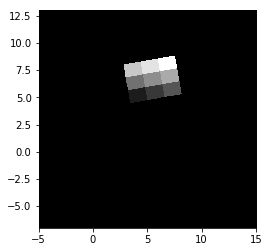

In [10]:
# Using the rotation parameter in the constructor may not be that easy
# to use: first you need to know the non-rotated boundaries, and then
# you rotate them. In case you know the coordinates of the bottomleft
# corner, the bottomright and topleft, you can use a different function.
# To illustrate, we'll calculate the corners of the rotated boundaries
# above, and use them in this function. 
a = np.pi/18.0
# The first coordinate is still the bottom left corner
p0 = np.array(bl, dtype=np.double)
# The second coordinate is the (rotated) bottom right corner
p1 = p0 + rotate(np.array([tr[0]-bl[0], 0]), a)
# The third coordinate it the (rotated) top left corner
p2 = p0 + rotate(np.array([0,tr[1]-bl[1]]), a)

g = gridfunction.GridFunction.createFromCorners(data, p0, p1, p2, True)
vals = g.evaluate(evalgrid, False)

plt.imshow(vals, interpolation="none", extent = [x0,x1,y1,y0], cmap = "gray")
plt.gca().invert_yaxis()

In [11]:
# The result already _looks_ the same as before; to show that they
# really are the same, let's verify that the differenc is zero
(vals-vals_A).min(), (vals-vals_A).max()

(0.0, 0.0)

In [12]:
# We can also create a grid function based on a FITS file
f = fits.open("jcqt30010_drz.fits")

f0 = f[1]
w = wcs.WCS(f0.header)
y, x = np.array(f0.data.shape)//2

# Let's use the central pixel as the center of the coordinate system
center = np.array(w.all_pix2world(x, y, 0))*ANGLE_DEGREE

In [13]:
g = gridfunction.GridFunction.createFromFITS(f0, center, True)

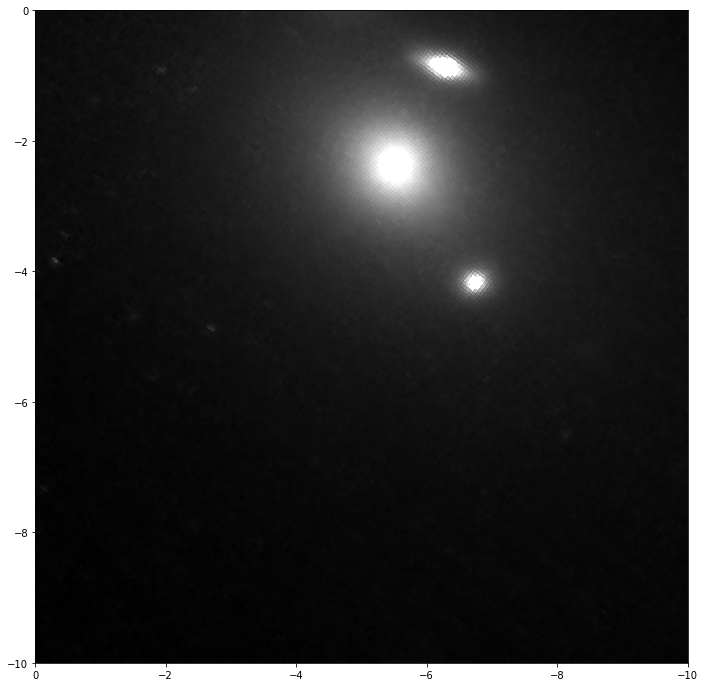

In [14]:
# Evaluate this grid function on a small part, and plot that
bl = np.array([-10, -10],dtype=np.double)*ANGLE_ARCSEC
tr = np.array([0, 0],dtype=np.double)*ANGLE_ARCSEC
evalgrid = createThetas(bl, tr, 2048, 2048)

vals = g.evaluate(evalgrid, False)

plt.figure(figsize=(12,12))
plt.imshow(vals.clip(0,1), interpolation="none", extent = np.array([bl[0],tr[0],tr[1],bl[1]])/ANGLE_ARCSEC, cmap = "gray")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

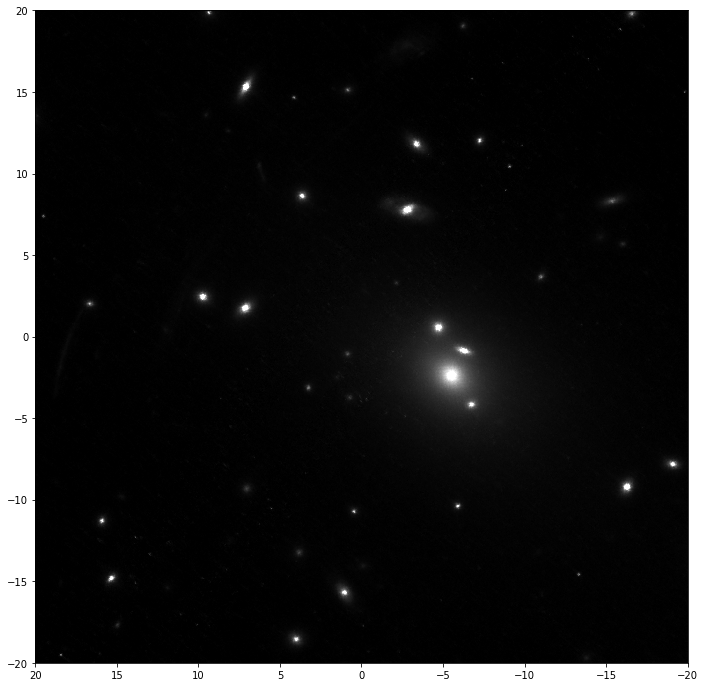

In [15]:
bl = np.array([-20, -20],dtype=np.double)*ANGLE_ARCSEC
tr = np.array([20, 20],dtype=np.double)*ANGLE_ARCSEC

evalgrid = createThetas(bl, tr, 2048, 2048)
vals = g.evaluate(evalgrid, False)

plt.figure(figsize=(12,12))
plt.imshow(vals.clip(0,1), interpolation="none", extent = np.array([bl[0],tr[0],tr[1],bl[1]])/ANGLE_ARCSEC, cmap = "gray")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [16]:
# Create a subdivision grid based on the FITS file, and plot it
cells = grid.createSubdivisionGridForFITS(f0, center, 20*ANGLE_ARCSEC, [0,0], 900, 1000)

/home/jori/anaconda3-501/envs/grale2env/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


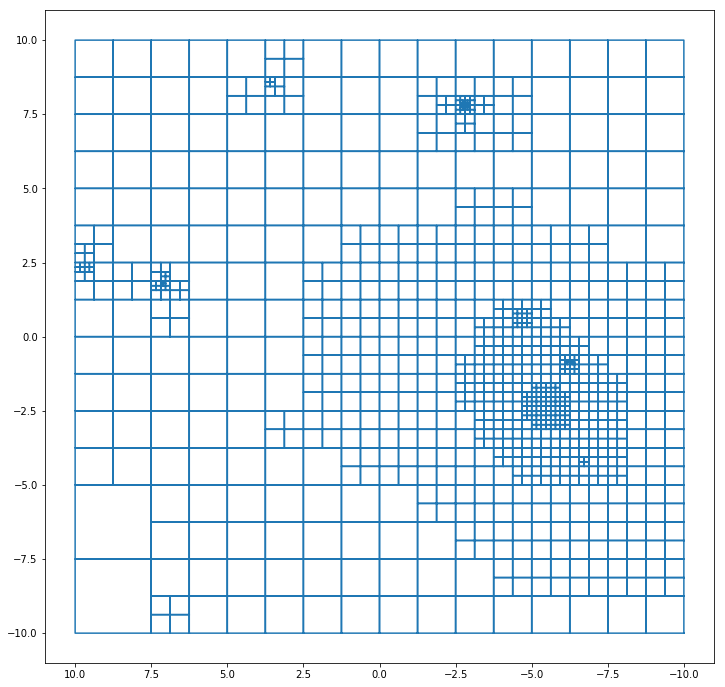

In [17]:
plt.figure(figsize=(12,12))
xp, yp = plotutil.plotSubdivisionGrid(cells, ANGLE_ARCSEC)
plt.gca().invert_xaxis()

In [18]:
# Just for fun, we'll fit a multiple plummer lens to the FITS based grid function,
# so we're basing the mass distribution on what's visible in the FITS file. Note
# that we're just using units from the FITS file, which probably don't make sense
# as mass densities
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)

zd = 0.348
Dd = cosm.getAngularDiameterDistance(zd)
l = grid.fitMultiplePlummerLens(cells, Dd, g.evaluate)

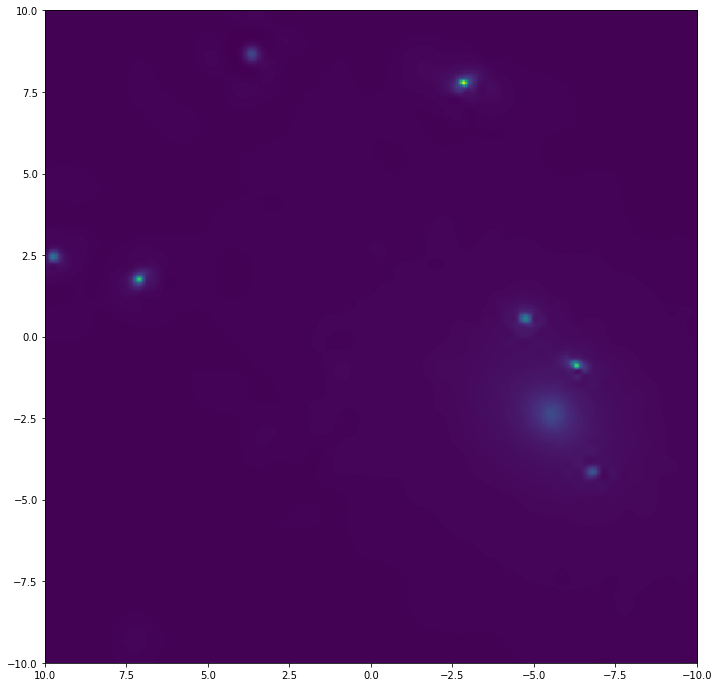

In [19]:
# Let's plot out fit!
plt.figure(figsize=(12,12))
lensInfo = plotutil.plotDensity({ "lens": l, "bottomleft": -V(10,10)*ANGLE_ARCSEC, "topright": V(10,10)*ANGLE_ARCSEC})
plt.gca().invert_xaxis()

In [20]:
# When creating a subdivision grid, we can also specify a so-class
# 'excludeFunction'. This takes the center and size of a grid cell
# as input, and should return False if this cell should be excluded
# from the grid. This way, for example, we could cut a hole in the
# grid

# The center of our hole
ec = [ -5*ANGLE_ARCSEC, 1*ANGLE_ARCSEC ]
# The radius
es = 2.5*ANGLE_ARCSEC

def excludeFunction(c, s):
    if ( (c[0]+s/2-ec[0])**2 + (c[1]+s/2-ec[1])**2 < es**2 and
         (c[0]-s/2-ec[0])**2 + (c[1]+s/2-ec[1])**2 < es**2 and
         (c[0]+s/2-ec[0])**2 + (c[1]-s/2-ec[1])**2 < es**2 and
         (c[0]-s/2-ec[0])**2 + (c[1]+s/2-ec[1])**2 < es**2 ):
        return True
    return False

cells = grid.createSubdivisionGridForFITS(f0, center, 20*ANGLE_ARCSEC, [0,0], 900, 1000, excludeFunction=excludeFunction)

/home/jori/anaconda3-501/envs/grale2env/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


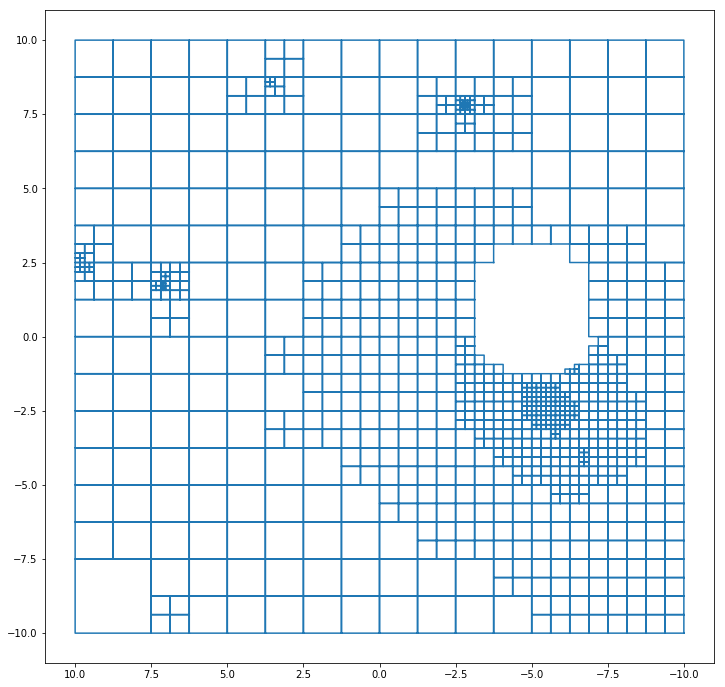

In [21]:
# If we now plot the grid again, we can see that there's a hole at
# the specified location
plt.figure(figsize=(12,12))
xp, yp = plotutil.plotSubdivisionGrid(cells, ANGLE_ARCSEC)
plt.gca().invert_xaxis()